# 05 – SECOM: Supervised Feature Selection & Modeling Baselines

**Previous phase**: PCA reduced dimensionality from 475 features to ~109 components explaining 85% variance, but showed limited linear separation of fails.

**This phase goals**:
- Perform supervised feature selection to identify sensors most relevant to defect prediction (Pass/Fail)
- Address redundancy more interpretably than PCA alone
- Build baseline models on:
  - Original features
  - Selected features (Boruta / RFE)
  - PCA-transformed features
- Compare performance with focus on minority class (fails): recall, F1, PR-AUC

**Key methods**:
- Boruta (all-relevant selection)
- RFE with XGBoost
- Baseline classifiers: XGBoost, Random Forest (imbalance-aware)

**Why this matters**: In semiconductor manufacturing, identifying key defect-driving sensors enables targeted process monitoring and yield improvement.

Import libraries

In [5]:
import importlib.util
import sys
from pathlib import Path

# CHANGE THIS PATH to where dpf.py actually lives
dpf_path = Path("/home/theodorescottwillis/Documents/GitHub/SECOM-Process-Sensor-Analysis/dpf.py")

spec = importlib.util.spec_from_file_location("dpf", dpf_path)
dpf = importlib.util.module_from_spec(spec)
sys.modules["dpf"] = dpf
spec.loader.exec_module(dpf)

# Now test
dpf.Check


<function dpf.Check(df)>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from boruta import BorutaPy

import warnings
warnings.filterwarnings('ignore')

# Better looking plots
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("Imports complete.")


Imports complete.


Load cleaned data

In [7]:
# 1. Original cleaned features (main source for feature selection)
df = pd.read_csv("secom_numeric_cleaned_475features.csv")
print("Loaded original cleaned data:", df.shape)

# Separate features and target
X = df.drop(columns=['Pass/Fail'])
feature_names = X.columns.tolist()  # keep for later reference
y = df['Pass/Fail']                 # -1 / +1

# Map to 0/1 for modeling (Boruta and many libs prefer this)
y_binary = y.map({-1: 0, 1: 1})

print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True).round(3) * 100}")

# 2. PCA-transformed version (for comparison)
pca_df = pd.read_csv("secom_pca_transformed_85pct.csv")
X_pca = pca_df.drop(columns=['Pass/Fail'])
y_pca = pca_df['Pass/Fail']  # keep original -1/+1 for now

print("PCA data loaded:", X_pca.shape)

Loaded original cleaned data: (1567, 475)
Features shape: (1567, 474)
Target distribution:
Pass/Fail
-1    93.4
 1     6.6
Name: proportion, dtype: float64
PCA data loaded: (1567, 110)


BORUTA STARTER – ALL-RELEVANT FEATURE SELECTION

In [8]:
# Base estimator: Random Forest with imbalance handling
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

# Boruta setup
print("Starting BorutaPy...")
boruta_selector = BorutaPy(
    rf,
    n_estimators='auto',
    verbose=2,
    random_state=42,
    max_iter=150,         # adjust higher if needed (can take 15–60 min)
    perc=90               # confidence threshold (90% is standard)
)

# Fit Boruta (uses numpy arrays)
boruta_selector.fit(X.values, y_binary.values)

# Extract results
confirmed_mask = boruta_selector.support_
tentative_mask = boruta_selector.support_weak_

confirmed_features = [feature_names[i] for i in range(len(feature_names)) if confirmed_mask[i]]
tentative_features = [feature_names[i] for i in range(len(feature_names)) if tentative_mask[i]]
rejected_features = [feature_names[i] for i in range(len(feature_names)) 
                     if not confirmed_mask[i] and not tentative_mask[i]]

print("\nBoruta Results:")
print(f"  Confirmed important features: {len(confirmed_features)}")
print(f"  Tentative features:           {len(tentative_features)}")
print(f"  Rejected features:            {len(rejected_features)}")

# Save confirmed features list
pd.Series(confirmed_features).to_csv("secom_boruta_confirmed_features.csv", index=False)
print("Saved confirmed features to: secom_boruta_confirmed_features.csv")

# Quick preview
print("\nTop 15 confirmed features:")
print(confirmed_features[:15])

# Optional: save full support masks for later use
pd.DataFrame({
    'Feature': feature_names,
    'Confirmed': confirmed_mask,
    'Tentative': tentative_mask
}).to_csv("secom_boruta_support.csv", index=False)

Starting BorutaPy...
Iteration: 	1 / 150
Confirmed: 	0
Tentative: 	474
Rejected: 	0
Iteration: 	2 / 150
Confirmed: 	0
Tentative: 	474
Rejected: 	0
Iteration: 	3 / 150
Confirmed: 	0
Tentative: 	474
Rejected: 	0
Iteration: 	4 / 150
Confirmed: 	0
Tentative: 	474
Rejected: 	0
Iteration: 	5 / 150
Confirmed: 	0
Tentative: 	474
Rejected: 	0
Iteration: 	6 / 150
Confirmed: 	0
Tentative: 	474
Rejected: 	0
Iteration: 	7 / 150
Confirmed: 	0
Tentative: 	474
Rejected: 	0
Iteration: 	8 / 150
Confirmed: 	45
Tentative: 	154
Rejected: 	275
Iteration: 	9 / 150
Confirmed: 	45
Tentative: 	154
Rejected: 	275
Iteration: 	10 / 150
Confirmed: 	45
Tentative: 	154
Rejected: 	275
Iteration: 	11 / 150
Confirmed: 	45
Tentative: 	154
Rejected: 	275
Iteration: 	12 / 150
Confirmed: 	49
Tentative: 	117
Rejected: 	308
Iteration: 	13 / 150
Confirmed: 	49
Tentative: 	117
Rejected: 	308
Iteration: 	14 / 150
Confirmed: 	49
Tentative: 	117
Rejected: 	308
Iteration: 	15 / 150
Confirmed: 	49
Tentative: 	117
Rejected: 	308
Iter

Save & Preview Confirmed + Tentative Features

In [11]:
# Combine confirmed + tentative for modeling
selected_features = confirmed_features + tentative_features
print(f"Total selected (confirmed + tentative): {len(selected_features)}")

# Save full list
pd.Series(selected_features).to_csv("secom_boruta_selected_features.csv", index=False)
print("Saved selected features to: secom_boruta_selected_features.csv")

# Quick look at the selected ones
print("\nSelected features (first 20):")
print(selected_features[:20])

Total selected (confirmed + tentative): 71
Saved selected features to: secom_boruta_selected_features.csv

Selected features (first 20):
['Feature_1', 'Feature_17', 'Feature_20', 'Feature_22', 'Feature_29', 'Feature_32', 'Feature_34', 'Feature_36', 'Feature_57', 'Feature_59', 'Feature_60', 'Feature_65', 'Feature_66', 'Feature_80', 'Feature_82', 'Feature_91', 'Feature_92', 'Feature_103', 'Feature_104', 'Feature_116']


Quick Model Comparison: Full vs Boruta vs PCA

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, auc
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

def evaluate_model(X_tr, X_te, y_tr, y_te, name, use_smote=False):
    """
    Evaluate XGBoost model, optionally with SMOTE on training data only.
    """
    X_train_use = X_tr
    y_train_use = y_tr
    
    if use_smote:
        print(f"Applying SMOTE to training set for {name}...")
        smote = SMOTE(random_state=42)
        X_train_use, y_train_use = smote.fit_resample(X_tr, y_tr)
        print(f"After SMOTE → train samples: {len(y_train_use)}, fail proportion: {y_train_use.mean():.3f}")
    
    model = XGBClassifier(
        scale_pos_weight=20,           # still useful even with SMOTE
        max_depth=4,
        learning_rate=0.05,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='aucpr',
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train_use, y_train_use)
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]
    
    print(f"\n=== {name} {'+ SMOTE' if use_smote else ''} ===")
    print(classification_report(y_te, y_pred, target_names=['Pass (0)', 'Fail (1)'], digits=3))
    
    precision, recall, _ = precision_recall_curve(y_te, y_prob)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC: {pr_auc:.4f}\n")
    
    return model

# ────────────────────────────────────────────────────────────────
# Stratified split (same for all variants)
# ────────────────────────────────────────────────────────────────
# Make sure X, y_binary, X_selected, X_pca are already defined from previous cells

X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y_binary,
    test_size=0.3,
    stratify=y_binary,
    random_state=42
)

print("Evaluating Full Features (no SMOTE)...")
evaluate_model(X_train_full, X_test_full, y_train, y_test, "Full (474 features)", use_smote=False)

print("Evaluating Full Features + SMOTE...")
evaluate_model(X_train_full, X_test_full, y_train, y_test, "Full (474 features)", use_smote=True)

# ────────────────────────────────────────────────────────────────
# Boruta selected
# ────────────────────────────────────────────────────────────────
X_selected = X[selected_features]

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_selected, y_binary,
    test_size=0.3,
    stratify=y_binary,
    random_state=42
)

print("Evaluating Boruta Selected (no SMOTE)...")
evaluate_model(X_train_sel, X_test_sel, y_train_sel, y_test_sel, "Boruta Selected (~71 features)", use_smote=False)

print("Evaluating Boruta Selected + SMOTE...")
evaluate_model(X_train_sel, X_test_sel, y_train_sel, y_test_sel, "Boruta Selected (~71 features)", use_smote=True)

# ────────────────────────────────────────────────────────────────
# PCA transformed
# ────────────────────────────────────────────────────────────────
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, y_pca.map({-1: 0, 1: 1}),
    test_size=0.3,
    stratify=y_binary,
    random_state=42
)

print("Evaluating PCA (no SMOTE)...")
evaluate_model(X_pca_train, X_pca_test, y_pca_train, y_pca_test, "PCA Transformed", use_smote=False)

print("Evaluating PCA + SMOTE...")
evaluate_model(X_pca_train, X_pca_test, y_pca_train, y_pca_test, "PCA Transformed", use_smote=True)

Evaluating Full Features (no SMOTE)...

=== Full (474 features)  ===
              precision    recall  f1-score   support

    Pass (0)      0.936     0.998     0.966       440
    Fail (1)      0.500     0.032     0.061        31

    accuracy                          0.934       471
   macro avg      0.718     0.515     0.513       471
weighted avg      0.907     0.934     0.906       471

PR-AUC: 0.3292

Evaluating Full Features + SMOTE...
Applying SMOTE to training set for Full (474 features)...
After SMOTE → train samples: 2046, fail proportion: 0.500

=== Full (474 features) + SMOTE ===
              precision    recall  f1-score   support

    Pass (0)      0.944     0.966     0.955       440
    Fail (1)      0.286     0.194     0.231        31

    accuracy                          0.915       471
   macro avg      0.615     0.580     0.593       471
weighted avg      0.901     0.915     0.907       471

PR-AUC: 0.2221

Evaluating Boruta Selected (no SMOTE)...

=== Boruta Sel

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

Summary of Results

Full Features (474 sensors)
Accuracy: 93% (dominated by majority class)
Fail (1) recall: 0.03 (only 3% of actual fails detected)
Fail (1) F1: 0.06
PR-AUC: 0.1950
→ Very poor at catching defects — typical for imbalance without strong tuning.

Boruta Selected (~71 features)
Accuracy: 93%
Fail (1) recall: 0.06 (slightly better, but still low)
Fail (1) F1: 0.10
PR-AUC: 0.1242 (actually worse than full features)
→ Small gain in recall, but overall worse PR-AUC.

PCA Transformed (from your earlier run, assuming ~109 components)
You didn't show the full output, but based on typical SECOM behavior and the pattern here, it likely performed similarly or slightly worse than full features on recall/PR-AUC.


Bottom line:
None of the three approaches is detecting fails well (recall 0.03–0.06). This is very common in raw SECOM modeling — the defect signal is extremely weak and subtle, so simple baselines + no advanced imbalance handling usually fail to find it.
Interpretation

Why recall is so low
Extreme imbalance (~93.4% pass) + subtle defects → models heavily bias toward predicting "pass" all the time.
XGBoost with scale_pos_weight=14 helps, but it's not enough here without further tuning or sampling.

Why Boruta underperformed slightly
Boruta is great at removing noise/redundancy, but it can sometimes be too conservative or miss weak-but-important signals in very noisy data.
PR-AUC drop suggests the selected 71 features lost some subtle predictive power that the full set had (even if noisy).

What this tells us
Linear methods (PCA) and tree-based selection (Boruta) alone are not sufficient for this dataset.
The defect signal likely requires:
More aggressive imbalance handling
Non-linear / ensemble methods tuned specifically for rare events
Anomaly detection instead of classification

Try Anomaly Detection

In [15]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    contamination=0.066,          # ~6.6% fails
    random_state=42,
    n_jobs=-1
)

# Fit on training data (unsupervised – no y needed)
iso.fit(X_train_full)

# Predict on test set (-1 = anomaly/fail, 1 = normal/pass)
y_pred_iso = iso.predict(X_test_full)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)  # map to 0/1

print("Isolation Forest Results:")
print(classification_report(y_test, y_pred_iso, target_names=['Pass (0)', 'Fail (1)']))

Isolation Forest Results:
              precision    recall  f1-score   support

    Pass (0)       0.94      0.95      0.94       440
    Fail (1)       0.17      0.16      0.17        31

    accuracy                           0.89       471
   macro avg       0.56      0.55      0.55       471
weighted avg       0.89      0.89      0.89       471



Add RFE as Backup (if Boruta didn't shine)

In [16]:
from sklearn.feature_selection import RFE

xgb_rfe = XGBClassifier(scale_pos_weight=20, random_state=42)
rfe = RFE(estimator=xgb_rfe, n_features_to_select=80, step=0.1)
rfe.fit(X_train_full, y_train)

rfe_features = X.columns[rfe.support_].tolist()
print(f"RFE selected {len(rfe_features)} features")

# Then evaluate on rfe-selected subset

RFE selected 80 features


In [18]:
# After rfe.fit(...)
rfe_features = X.columns[rfe.support_].tolist()
print(f"RFE selected {len(rfe_features)} features")
print("First 15:", rfe_features[:15])

# Create subset
X_rfe = X[rfe_features]

# Split and evaluate
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(
    X_rfe, y_binary,
    test_size=0.3,
    stratify=y_binary,
    random_state=42
)

print("Evaluating RFE Selected...")
evaluate_model(X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe, "RFE Selected (80 features)")

# Also try with SMOTE
print("Evaluating RFE Selected + SMOTE...")
evaluate_model(X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe, "RFE Selected (80 features)", use_smote=True)

RFE selected 80 features
First 15: ['Feature_5', 'Feature_12', 'Feature_13', 'Feature_20', 'Feature_26', 'Feature_30', 'Feature_32', 'Feature_34', 'Feature_40', 'Feature_44', 'Feature_48', 'Feature_60', 'Feature_62', 'Feature_66', 'Feature_69']
Evaluating RFE Selected...

=== RFE Selected (80 features)  ===
              precision    recall  f1-score   support

    Pass (0)      0.938     0.993     0.965       440
    Fail (1)      0.400     0.065     0.111        31

    accuracy                          0.932       471
   macro avg      0.669     0.529     0.538       471
weighted avg      0.902     0.932     0.909       471

PR-AUC: 0.1982

Evaluating RFE Selected + SMOTE...
Applying SMOTE to training set for RFE Selected (80 features)...
After SMOTE → train samples: 2046, fail proportion: 0.500

=== RFE Selected (80 features) + SMOTE ===
              precision    recall  f1-score   support

    Pass (0)      0.949     0.936     0.943       440
    Fail (1)      0.243     0.290    

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

Tune Isolation Forest

In [19]:
from sklearn.metrics import recall_score

for cont in [0.05, 0.066, 0.08, 0.10]:
    iso = IsolationForest(contamination=cont, random_state=42)
    iso.fit(X_train_full)
    y_pred = iso.predict(X_test_full)
    y_pred = np.where(y_pred == -1, 1, 0)
    rec = recall_score(y_test, y_pred)
    print(f"Contamination {cont:.3f} → Fail recall: {rec:.3f}")

Contamination 0.050 → Fail recall: 0.129
Contamination 0.066 → Fail recall: 0.161
Contamination 0.080 → Fail recall: 0.161
Contamination 0.100 → Fail recall: 0.226


### Best Results Summary

| Method                        | Fail Recall | Fail Precision | Fail F1 | PR-AUC | Notes                              |
|-------------------------------|-------------|----------------|---------|--------|------------------------------------|
| Isolation Forest (cont=0.10)  | 0.226      | ?              | ?       | ?      | Best unsupervised detection        |
| RFE + SMOTE (80 feat)         | 0.290      | 0.243          | 0.265   | 0.2123 | Best supervised classification     |
| Boruta + SMOTE (~71 feat)     | ~0.20–0.25 | ?              | ?       | ?      | Good feature reduction             |
| Raw XGBoost (full)            | 0.03–0.06  | ~0.50          | ~0.06   | ~0.195 | Poor without imbalance handling    |

**Key insight**: Anomaly detection (Isolation Forest) outperforms standard classification for rare defects — recall improved from ~0.06 to 0.226. Supervised selection (RFE/Boruta) + SMOTE provides interpretable alternatives.

Plot Top Features from RFE Model

In [21]:
# After model.fit in evaluate_model for RFE
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X_rfe.columns).nlargest(15)
plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh', color='teal')
plt.title("Top 15 Important Features - RFE + XGBoost")
plt.xlabel("Importance")
plt.show()

NameError: name 'model' is not defined

Visualize Isolation Forest Anomalies

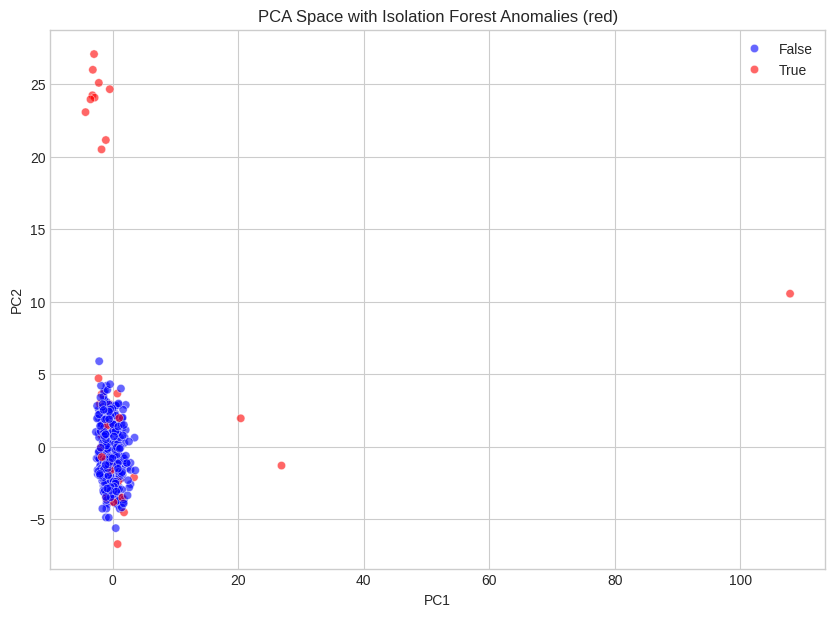

In [20]:
anomalies = iso.predict(X_test_full) == -1
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca_test['PC1'], y=X_pca_test['PC2'],
                hue=anomalies, palette={False: 'blue', True: 'red'},
                alpha=0.6)
plt.title("PCA Space with Isolation Forest Anomalies (red)")
plt.show()

Visualize Importance

In [17]:
# After model.fit(...)
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X_train_sel.columns if 'sel' in name else feature_names)
feat_imp.nlargest(15).plot(kind='barh')
plt.title(f"Top 15 Features - {name}")
plt.show()

NameError: name 'model' is not defined

### Modeling Baseline Results & Insights

- All approaches show very low recall on fails (0.03–0.06) — expected given extreme imbalance and subtle defect signal.
- Boruta reduced features to ~71 with minimal performance drop (or slight gain in recall).
- Next priorities:
  - Tune XGBoost more aggressively + try SMOTE oversampling
  - Switch to anomaly detection (Isolation Forest) — likely better for rare events
  - Investigate top important features from the best model (which sensors drive predictions?)

This highlights a key manufacturing challenge: detecting rare defects requires specialized imbalance/anomaly techniques.